In [8]:
import numpy as np
import pandas as pd
import plotly.express as px
import holidays
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler
from statsmodels.tsa.seasonal import STL


from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

In [9]:
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
#열이름빼기
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
#Unnamed:0제거
df_train = df_train.drop(columns=["Unnamed: 0"])
#test데이터 열이름 바꾸기
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"]

df_train = df_train[df_train['branch_id'] == 'B'].copy()
df_test = df_test[df_test['branch_id'] == 'B'].copy()


def calculate_summer_apparent_temp(ta, hm):
    """여름철 체감온도 계산"""
    try:
        tw = ta * np.arctan(0.151977 * np.sqrt(hm + 8.313659)) \
             + np.arctan(ta + hm) \
             - np.arctan(hm - 1.676331) \
             + 0.00391838 * hm**1.5 * np.arctan(0.023101 * hm) \
             - 4.686035
        return -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    except:
        return np.nan

def calculate_winter_apparent_temp(ta, ws):
    """겨울철 체감온도 계산"""
    try:
        v = ws * 3.6  # m/s → km/h
        return 13.12 + 0.6215 * ta - 11.37 * v**0.16 + 0.3965 * ta * v**0.16
    except:
        return np.nan

def add_apparent_temp_features(df):
    df['month'] = df['tm'].dt.month
    df['apparent_temp'] = df.apply(lambda row:
        calculate_summer_apparent_temp(row['ta'], row['hm']) if 5 <= row['month'] <= 9
        else calculate_winter_apparent_temp(row['ta'], row['ws']),
        axis=1
    )
    return df


def branchwise_svr_impute(df, col, time_col='tm'):
    df = df.copy()
    # 시간 컬럼을 숫자형으로 변환 (timestamp, 초 단위)
    df['_time_num'] = pd.to_datetime(df[time_col]).astype(np.int64) // 10**9
    # branch별로 SVR 보간
    def impute_group(g):
        return svr_impute_series(g[col], g['_time_num'])
    # apply 결과를 원래 인덱스에 맞게 할당
    df[col] = df.groupby('branch_id', group_keys=False).apply(impute_group)
    df = df.drop(columns=['_time_num'])
    return df


def preprocess_weather_data(df):
    # 날짜 변환
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    # 1. si: 08~18시가 아닐 때 -99는 0으로
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0

    # 2. wd에서 9.9는 NaN으로
    df['wd'] = df['wd'].replace(9.9, np.nan)

    # 3. -99 처리
    df.replace(-99, np.nan, inplace=True)


    # SVR 보간
    df = df.sort_values(['branch_id', 'tm'])

    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()

        # 시간 특성 생성
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month

        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()

                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask

                    # 예측할 데이터 준비
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values

                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()

                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)

                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        # 보간 결과 반영
                        df.loc[branch_mask & missing_mask, col] = y_pred

                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')

                # 남은 결측 ffill/bfill로 제거
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')

        print("✅")

    print("🎉 SVR 보간 완료 (조건 없이 전부 시도)")
    #보간후 음수나올 가능성존재
    df.loc[df['ta'] < 0, 'ta'] = 0
    df.loc[df['ws'] < 0, 'ws'] = 0

    # 📌 파생 변수 생성
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['hour'] = df['tm'].dt.hour
    df['date'] = df['tm'].dt.date
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

    # 🇰🇷 한국 공휴일
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['tm'].dt.date.apply(lambda x: int(x in kr_holidays))

    # 🕒 시간 지연
    for lag in [1, 2, 3]:
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')['ta'].shift(lag)
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')[f'ta_lag_{lag}'].transform(
        lambda x: x.fillna(method='bfill'))
    # 🔥 HDD / CDD
    df['HDD18'] = np.maximum(0, 18 - df['ta'])
    #df['CDD18'] = np.maximum(0, df['ta'] - 18)
    df['HDD20'] = np.maximum(0, 20 - df['ta'])
    #df['CDD20'] = np.maximum(0, df['ta'] - 20)

    #직접만든 체감온도
    df = add_apparent_temp_features(df)


    # 지점별 온도 편차
    branch_mean = df.groupby('branch_id')['ta'].transform('mean')
    df['branch_temp_abs_deviation'] = np.abs(df['ta'] - branch_mean)



    # 이동 평균 (3시간 단위 최대 24시간 = 8개)
    for n in [3, 6, 9, 12, 15, 18, 21, 24]:
        df[f'ta_3h_avg_{n}'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(n, min_periods=1).mean())

    # 불쾌지수
    df['DCI'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3

    # 풍속 냉지수 (wchi)
    ws_kmh = df['ws'] * 3.6  # m/s -> km/h 변환
    df['wchi'] = 13.12 + 0.6215 * df['ta'] - 11.37 * ws_kmh**0.16 + 0.3965 * df['ta'] * ws_kmh**0.16

     # 풍속 고려 체감온도 (wind chill)
    df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * df['ws']**0.16 + 0.3965 * df['ta'] * df['ws']**0.16

    # 실효온도
    df['e'] = (df['hm'] / 100) * 6.105 * np.exp((17.27 * df['ta']) / (237.7 + df['ta']))
    df['atemphi'] = df['ta'] + 0.33 * df['e'] - 0.70 * df['ws'] - 4.00

    # 주기성 인코딩
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['dayofmonth'] = df['tm'].dt.day
    df['weekofyear'] = df['tm'].dt.isocalendar().week.astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    # 하루 5구간
    def time_slot(h): return int(h // 5)
    df['hour_slot_5'] = df['hour'].apply(time_slot)

    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        # 인덱스 이름을 명확히 지정
        s = pd.Series(fft_vals[:n], index=[f'fft_{i}' for i in range(n)])
        return s

    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        s = pd.Series(fft_vals[:n], index=pd.Index([f'fft_{i}' for i in range(n)], name='fft_idx'))
        return s

    fft_cols = ['ta', 'hm', 'ws', 'ta_chi', 'apparent_temp']
    fft_features = []
    branch_ids = df['branch_id'].unique()
    fft_feature_dict = {bid: {} for bid in branch_ids}
    for col in fft_cols:
        if col not in df.columns:
            continue
        for branch_id in branch_ids:
            arr = df.loc[df['branch_id'] == branch_id, col].fillna(0).values
            fft_vals = np.abs(fft(arr))[:10]
            for i, val in enumerate(fft_vals):
                fft_feature_dict[branch_id][f'Nph_{col}_{i}'] = val
                
    # DataFrame으로 변환
    fft_features_df = pd.DataFrame.from_dict(fft_feature_dict, orient='index')
    # 원본 df와 merge
    df = df.merge(fft_features_df, left_on='branch_id', right_index=True, how='left')

    # 기온 차분
    df['ta_diff_6h'] = df.groupby('branch_id')['ta'].diff(6).bfill()
    df['ta_diff_12h'] = df.groupby('branch_id')['ta'].diff(12).bfill()
    df['ta_diff_24h'] = df.groupby('branch_id')['ta'].diff(24).bfill()

    # 일교차
    df['day_ta_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('max')
    df['day_ta_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('min')
    df['daily_range'] = df['day_ta_max'] - df['day_ta_min']

    # 일교차 변화량
    df['daily_range_shift'] = df.groupby('branch_id')['daily_range'].shift(1).bfill()

    # 피크타임1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4

    # 피크타임2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1


    # heating season
    df['heating_season'] = df['month'].isin([10,11,12,1, 2, 3,4]).astype(int)

    # 온도 범주화
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])

    # 오전/오후
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # 계절
    def get_season(month):
        return {
            12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'fall', 10: 'fall', 11: 'fall'
        }.get(month, 'unknown')
    df['season'] = df['month'].apply(get_season)

    # 한파 주의보/경보
    df['cold_watch'] = (df['ta'] <= -12).astype(int)  # 주의보
    df['cold_warning'] = (df['ta'] <= -15).astype(int)  # 경보


    # 변환 대상 변수
    col = 'ta'
    '''
    df['ta_boxcox'] = np.nan
    df['ta_boxcox_lambda'] = np.nan
    df['ta_boxcox_shift'] = np.nan  # shift 값도 저장
    for branch, group in df.groupby('branch_id'):
        col = 'ta'
        min_val = group[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1e-4
        else:
            shift = 0
        shifted = group[col] + shift
        shifted = shifted.dropna()
        if shifted.nunique() > 1 and len(shifted) >= 2:
            transformed, fitted_lambda = boxcox(shifted)
            df.loc[shifted.index, 'ta_boxcox'] = transformed
            df.loc[shifted.index, 'ta_boxcox_lambda'] = fitted_lambda
            df.loc[shifted.index, 'ta_boxcox_shift'] = shift
        else:
            df.loc[group.index, 'ta_boxcox'] = np.nan
            df.loc[group.index, 'ta_boxcox_lambda'] = np.nan
            df.loc[group.index, 'ta_boxcox_shift'] = shift


    '''
    df = df.drop(columns=['date'])



    return df
#상호작용 처리못함
#군집화된 전처리 못함


#정규화 일단 min max +원핫인코딩
def scale_encode(df):
    cat_cols = [
         'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20',
        'afternoon', 'season','month','day','hour'
    ]

    # 범주형 변수 category화
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 연속형 변수만 추출 (타겟, 날짜 등 제외)
    exclude_cols = ['heat_demand', 'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season','month','day','hour']
    num_cols = [col for col in df.columns
                if (df[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

    # MinMaxScaler 적용
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])


    return df



df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)


df_train = scale_encode(df_train)
df_test = scale_encode(df_test)

df_train.to_csv('df_train_prescale.csv', index=True)
df_test.to_csv('df_test_prescale.csv', index=True)

   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)


KeyError: "['  date'] not found in axis"

In [3]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['year'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [4]:
def run_3fold_pipeline_with_residual(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]
    X = df_train[features]
    y = df_train[target_col]

    n = len(df_train)
    fold_size = n // 3

    val_rmses = []
    test_preds = []

    print(f"전체 데이터 길이: {n}, Fold 크기: {fold_size}\n")

    for fold in range(2):  # Fold 0, 1 수행 (3번째는 테스트용 데이터 분리)
        train_end = fold_size * (fold + 1)
        val_end = fold_size * (fold + 2)

        X_train = X.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_val = X.iloc[train_end:val_end]
        y_val = y.iloc[train_end:val_end]

        print(f"===== Fold {fold+1} =====")
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

        # 1) LightGBM 베이지안 최적화 함수
        def lgb_objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, val_pred))

        lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        lgb_study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)

        best_lgb_params = lgb_study.best_params
        best_lgb_params.update({
            'objective': 'huber',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        # 2) LightGBM 최적 모델 학습
        lgb_model = lgb.LGBMRegressor(**best_lgb_params)
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
        )

        val_pred_lgb = lgb_model.predict(X_val)
        val_rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
        print(f"LightGBM Fold {fold+1} Validation RMSE: {val_rmse_lgb:.4f}")

        # 3) 잔차 계산
        residual_train = y_train - lgb_model.predict(X_train)
        residual_val = y_val - val_pred_lgb

        # 4) XGBoost 베이지안 최적화 함수
        def xgb_objective(trial):
            params = {
                'objective': 'reg:squarederror',
                'n_estimators': trial.suggest_int('n_estimators', 100, 2000),  # upper bound ↑
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),  # lower bound ↓, upper bound ↓
                'max_depth': trial.suggest_int('max_depth', 2, 12),
                'subsample': trial.suggest_float('subsample', 0.8, 1.0),  # lower bound ↑
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),  # upper bound ↑
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),  # upper bound ↑
                'random_state': 42,
                'n_jobs': -1
            }

            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train, residual_train,
                eval_set=[(X_val, residual_val)],
                verbose=0
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(residual_val, val_pred))

        xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

        best_xgb_params = xgb_study.best_params
        best_xgb_params.update({
            'objective': 'reg:pseudohubererror',
            'random_state': 42,
            'n_jobs': -1
        })

        # 5) XGBoost 최적 모델 학습 (잔차 예측용)
        xgb_model = xgb.XGBRegressor(**best_xgb_params)
        xgb_model.fit(
            X_train, residual_train,
            eval_set=[(X_val, residual_val)],
            verbose=100
        )

        val_pred_residual = xgb_model.predict(X_val)
        val_pred_final = val_pred_lgb + val_pred_residual
        val_rmse_final = np.sqrt(mean_squared_error(y_val, val_pred_final))
        print(f"Residual Stacking Fold {fold+1} Validation RMSE: {val_rmse_final:.4f}")

        val_rmses.append(val_rmse_final)

        # 테스트는 마지막에 평균 예측 위해 저장
        test_pred_lgb = lgb_model.predict(df_test[features])
        test_pred_residual = xgb_model.predict(df_test[features])
        test_pred_fold = test_pred_lgb + test_pred_residual
        test_preds.append(test_pred_fold)

        print("-----------------------------")

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    print(f"\n최종 평균 Validation RMSE: {avg_val_rmse:.4f}")

    df_test[target_col] = avg_test_pred

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,   # 추가!
        'test_pred': avg_test_pred,
        'test_index': df_test.index
    }

[I 2025-06-22 03:37:35,926] A new study created in memory with name: no-name-e932bb5c-3dd7-4b1a-9502-7e2bbbe1bbbe


전체 데이터 길이: 17519, Fold 크기: 5839

===== Fold 1 =====
Train size: 5839, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 91.1922:   5%|▌         | 1/20 [00:00<00:09,  2.06it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[153]	valid_0's rmse: 91.1922
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:37:36,41

Best trial: 0. Best value: 91.1922:  10%|█         | 2/20 [00:00<00:06,  2.97it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 91.1922:  15%|█▌        | 3/20 [00:01<00:09,  1.87it/s]

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.5752867891211308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752867891211308
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[I 2025-06-22 03:37:37,416] Trial 2 finished with value: 95.78542254611952 and parameters: {'learning_rate': 0.04345454109729477, 'num_leaves': 94, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.5752867891211308, 'bagging_fraction': 0.619817105976215, 'bagging_freq': 4, 'reg_alpha': 7.851759613930136, 'reg_lambda': 1.9967378215835974}. Best is trial 0 with value: 91.19222931448861.
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20

Best trial: 0. Best value: 91.1922:  20%|██        | 4/20 [00:01<00:06,  2.41it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  25%|██▌       | 5/20 [00:02<00:07,  2.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[178]	valid_0's rmse: 89.0772
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:37:38,287] Trial 4 finished with value: 89.07720211486959 and parameters: {'learning_

Best trial: 4. Best value: 89.0772:  30%|███       | 6/20 [00:02<00:06,  2.19it/s]

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.5109126733153162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109126733153162
[LightGBM] [Warning] bagging_fraction is set=0.9817507766587351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817507766587351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[I 2025-06-22 03:37:38,667] Trial 5 finished with value: 104.66780671507186 and parameters: {'learning_rate': 0.09519754482692679, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 114, 'feature_fraction': 0.5109126733153162, 'bagging_fraction': 0.9817507766587351, 'bagging_freq': 6, 'reg_alpha': 9.394989415641891, 'reg_lambda': 8.948273504276488}. Best is trial 4 with value: 89.07720211486959.
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_sampl

Best trial: 4. Best value: 89.0772:  35%|███▌      | 7/20 [00:03<00:05,  2.20it/s]

[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] feature_fraction is set=0.4271363733463229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271363733463229
[LightGBM] [Warning] bagging_fraction is set=0.5951981984579586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5951981984579586
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-22 03:37:39,118] Trial 6 finished with value: 93.64529158818071 and parameters: {'learning_rate': 0.0764136186923332, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.4271363733463229, 'bagging_fraction': 0.5951981984579586, 'bagging_freq': 3, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 4 with value: 89.07720211486959.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20

Best trial: 4. Best value: 89.0772:  40%|████      | 8/20 [00:04<00:07,  1.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  45%|████▌     | 9/20 [00:05<00:07,  1.40it/s]

[I 2025-06-22 03:37:41,020] Trial 8 finished with value: 110.10201597793674 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 4 with value: 89.07720211486959.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_sam

Best trial: 4. Best value: 89.0772:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 03:37:41,244] Trial 9 finished with value: 104.34141802978843 and parameters: {'learning_rate': 0.08330803890301997, 'num_leaves': 106, 'max_depth': 3, 'min_data_in_leaf': 69, 'feature_fraction': 0.5951099932160482, 'bagging_fraction': 0.8377637070028385, 'bagging_freq': 5, 'reg_alpha': 8.872127425763265, 'reg_lambda': 4.722149251619493}. Best is trial 4 with value: 89.07720211486959.
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=

Best trial: 4. Best value: 89.0772:  55%|█████▌    | 11/20 [00:05<00:04,  1.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[84]	valid_0's rmse: 129.484
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.7217131532186557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7217131532186557
[LightGBM] [Warning] bagging_fraction is set=0.7644281754688748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76442

Best trial: 4. Best value: 89.0772:  60%|██████    | 12/20 [00:06<00:04,  1.65it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  65%|██████▌   | 13/20 [00:07<00:04,  1.57it/s]

[I 2025-06-22 03:37:43,159] Trial 12 finished with value: 91.05226136554171 and parameters: {'learning_rate': 0.021309082170288266, 'num_leaves': 230, 'max_depth': 12, 'min_data_in_leaf': 200, 'feature_fraction': 0.41642061982236134, 'bagging_fraction': 0.8623398761202057, 'bagging_freq': 1, 'reg_alpha': 7.299436732862953, 'reg_lambda': 3.4285850623111425}. Best is trial 4 with value: 89.07720211486959.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.8888702314029386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888702314029386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_

Best trial: 13. Best value: 87.1559:  70%|███████   | 14/20 [00:08<00:04,  1.37it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 87.1559:  75%|███████▌  | 15/20 [00:09<00:04,  1.12it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 15. Best value: 82.1519:  80%|████████  | 16/20 [00:11<00:04,  1.18s/it]

[I 2025-06-22 03:37:47,223] Trial 15 finished with value: 82.15193416095741 and parameters: {'learning_rate': 0.020756740873907675, 'num_leaves': 51, 'max_depth': 7, 'min_data_in_leaf': 12, 'feature_fraction': 0.4048236215996866, 'bagging_fraction': 0.7794895923263812, 'bagging_freq': 2, 'reg_alpha': 5.122018493767848, 'reg_lambda': 0.5820109365078552}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4022940396210904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4022940396210904
[LightGBM] [Warning] bagging_fraction is set=0.8722023075149075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722023075149075
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_sample

Best trial: 15. Best value: 82.1519:  85%|████████▌ | 17/20 [00:14<00:05,  1.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4022940396210904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4022940396210904
[LightGBM] [Warning] bagging_fraction is set=0.8722023075149075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722023075149075
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:37:50,785] Trial 16 finished with value: 82.39369989740463 and parameters: {'learning_rate': 0.01768129648932595, 'num_leaves': 160, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.4022940396210904, 'bagging_fraction': 0.8722023075149075, 'bagging_freq': 2, 'reg_alpha': 4.380260969709104, 'reg_lambda': 0.13179214380923554}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_sampl

Best trial: 15. Best value: 82.1519:  90%|█████████ | 18/20 [00:16<00:03,  1.82s/it]

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] feature_fraction is set=0.7758873481309698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7758873481309698
[LightGBM] [Warning] bagging_fraction is set=0.7857084583543332, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7857084583543332
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[I 2025-06-22 03:37:52,430] Trial 17 finished with value: 122.3548277132148 and parameters: {'learning_rate': 0.01585819185443179, 'num_leaves': 150, 'max_depth': 6, 'min_data_in_leaf': 19, 'feature_fraction': 0.7758873481309698, 'bagging_fraction': 0.7857084583543332, 'bagging_freq': 4, 'reg_alpha': 4.011780528648791, 'reg_lambda': 0.17423193244223042}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_sampl

Best trial: 15. Best value: 82.1519:  95%|█████████▌| 19/20 [00:20<00:02,  2.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6018664528876175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6018664528876175
[LightGBM] [Warning] bagging_fraction is set=0.913328604638754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913328604638754
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:37:56,670] Trial 18 finished with value: 101.84692141430497 and parameters: {'learning_rate': 0.013224587815606684, 'num_leaves': 61, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.6018664528876175, 'bagging_fraction': 0.913328604638754, 'bagging_freq': 2, 'reg_alpha': 0.901740529474278, 'reg_lambda': 1.3791290236962879}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=

Best trial: 15. Best value: 82.1519: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


[I 2025-06-22 03:37:57,411] Trial 19 finished with value: 106.22350455677139 and parameters: {'learning_rate': 0.025342408734938128, 'num_leaves': 134, 'max_depth': 5, 'min_data_in_leaf': 57, 'feature_fraction': 0.6258984741786953, 'bagging_fraction': 0.7900952345863482, 'bagging_freq': 4, 'reg_alpha': 3.4940093603535267, 'reg_lambda': 1.0539060314504374}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.7794895923263812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794895923263812
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_sam

[I 2025-06-22 03:37:59,329] A new study created in memory with name: no-name-eff2b3b4-accb-45a7-b375-d96ef0dd0e0e


[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.7794895923263812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794895923263812
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
LightGBM Fold 1 Validation RMSE: 210.8490
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.7794895923263812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794895923263812
[Lig

Best trial: 0. Best value: 113.098:   5%|▌         | 1/20 [00:14<04:31, 14.30s/it]

[I 2025-06-22 03:38:13,632] Trial 0 finished with value: 113.09817427989474 and parameters: {'n_estimators': 812, 'learning_rate': 0.04123206532618727, 'max_depth': 10, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 3.119890406724053, 'reg_lambda': 1.1616722433639892}. Best is trial 0 with value: 113.09817427989474.


Best trial: 0. Best value: 113.098:  10%|█         | 2/20 [00:40<06:21, 21.20s/it]

[I 2025-06-22 03:38:39,653] Trial 1 finished with value: 158.02813094866573 and parameters: {'n_estimators': 1746, 'learning_rate': 0.010502105436744277, 'max_depth': 9, 'subsample': 0.8041168988591605, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 16.648852816008436, 'reg_lambda': 4.246782213565523}. Best is trial 0 with value: 113.09817427989474.


Best trial: 0. Best value: 113.098:  15%|█▌        | 3/20 [00:42<03:35, 12.70s/it]

[I 2025-06-22 03:38:42,244] Trial 2 finished with value: 147.83342469707944 and parameters: {'n_estimators': 445, 'learning_rate': 0.002049268011541736, 'max_depth': 5, 'subsample': 0.9049512863264476, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 5.824582803960839, 'reg_lambda': 12.23705789444759}. Best is trial 0 with value: 113.09817427989474.


Best trial: 0. Best value: 113.098:  20%|██        | 4/20 [00:46<02:22,  8.92s/it]

[I 2025-06-22 03:38:45,365] Trial 3 finished with value: 156.73057183048473 and parameters: {'n_estimators': 365, 'learning_rate': 0.0031357757322577457, 'max_depth': 6, 'subsample': 0.8912139968434072, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 3.9934756431671947, 'reg_lambda': 10.284688768272233}. Best is trial 0 with value: 113.09817427989474.


Best trial: 0. Best value: 113.098:  25%|██▌       | 5/20 [00:58<02:30, 10.04s/it]

[I 2025-06-22 03:38:57,384] Trial 4 finished with value: 129.1668959093117 and parameters: {'n_estimators': 1226, 'learning_rate': 0.0011992724522955163, 'max_depth': 8, 'subsample': 0.8341048247374584, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 18.977710745066666, 'reg_lambda': 19.312640661491187}. Best is trial 0 with value: 113.09817427989474.


Best trial: 5. Best value: 97.4315:  30%|███       | 6/20 [01:04<02:03,  8.86s/it]

[I 2025-06-22 03:39:03,947] Trial 5 finished with value: 97.43150967370926 and parameters: {'n_estimators': 1636, 'learning_rate': 0.0032925293631105254, 'max_depth': 3, 'subsample': 0.9368466053024314, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 2.4407646968955765, 'reg_lambda': 9.903538202225404}. Best is trial 5 with value: 97.43150967370926.


Best trial: 5. Best value: 97.4315:  35%|███▌      | 7/20 [01:05<01:21,  6.24s/it]

[I 2025-06-22 03:39:04,816] Trial 6 finished with value: 99.54739694701404 and parameters: {'n_estimators': 165, 'learning_rate': 0.03506776499297219, 'max_depth': 4, 'subsample': 0.9325044568707964, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 10.401360423556216, 'reg_lambda': 10.934205586865593}. Best is trial 5 with value: 97.43150967370926.


Best trial: 5. Best value: 97.4315:  40%|████      | 8/20 [01:15<01:29,  7.45s/it]

[I 2025-06-22 03:39:14,840] Trial 7 finished with value: 149.52539365635008 and parameters: {'n_estimators': 451, 'learning_rate': 0.04439102767051398, 'max_depth': 10, 'subsample': 0.9878997883128378, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 11.957999576221702, 'reg_lambda': 18.437484700462335}. Best is trial 5 with value: 97.43150967370926.


Best trial: 5. Best value: 97.4315:  45%|████▌     | 9/20 [01:16<01:00,  5.46s/it]

[I 2025-06-22 03:39:15,939] Trial 8 finished with value: 157.7422198767664 and parameters: {'n_estimators': 268, 'learning_rate': 0.0021526280972215283, 'max_depth': 2, 'subsample': 0.8650660661526529, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 5.426980635477918, 'reg_lambda': 16.57475018303859}. Best is trial 5 with value: 97.43150967370926.


Best trial: 5. Best value: 97.4315:  50%|█████     | 10/20 [01:23<00:58,  5.85s/it]

[I 2025-06-22 03:39:22,660] Trial 9 finished with value: 149.3663681274298 and parameters: {'n_estimators': 778, 'learning_rate': 0.0030012301808980462, 'max_depth': 7, 'subsample': 0.8281848449949526, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 1.4910128735954165, 'reg_lambda': 19.737738732010346}. Best is trial 5 with value: 97.43150967370926.


Best trial: 5. Best value: 97.4315:  55%|█████▌    | 11/20 [02:20<03:15, 21.71s/it]

[I 2025-06-22 03:40:20,314] Trial 10 finished with value: 135.89390708813494 and parameters: {'n_estimators': 1956, 'learning_rate': 0.008901658169707404, 'max_depth': 12, 'subsample': 0.9740987279549387, 'colsample_bytree': 0.8200442512337782, 'reg_alpha': 8.128577198325285, 'reg_lambda': 6.620921634331682}. Best is trial 5 with value: 97.43150967370926.


Best trial: 11. Best value: 87.6922:  60%|██████    | 12/20 [02:26<02:14, 16.79s/it]

[I 2025-06-22 03:40:25,859] Trial 11 finished with value: 87.69224989159167 and parameters: {'n_estimators': 1399, 'learning_rate': 0.018414355854512118, 'max_depth': 3, 'subsample': 0.9436760764283505, 'colsample_bytree': 0.6322311441087203, 'reg_alpha': 12.668141477021702, 'reg_lambda': 13.048208028644844}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  65%|██████▌   | 13/20 [02:31<01:32, 13.27s/it]

[I 2025-06-22 03:40:31,041] Trial 12 finished with value: 88.33117042205026 and parameters: {'n_estimators': 1426, 'learning_rate': 0.016374656042383195, 'max_depth': 2, 'subsample': 0.9535115643516741, 'colsample_bytree': 0.6197950354034808, 'reg_alpha': 14.015520854235852, 'reg_lambda': 14.760728928863225}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  70%|███████   | 14/20 [02:36<01:04, 10.74s/it]

[I 2025-06-22 03:40:35,943] Trial 13 finished with value: 90.11517280307406 and parameters: {'n_estimators': 1382, 'learning_rate': 0.017689707581156722, 'max_depth': 2, 'subsample': 0.9619464519733012, 'colsample_bytree': 0.611885828341315, 'reg_alpha': 14.052942358454416, 'reg_lambda': 14.239556044268234}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  75%|███████▌  | 15/20 [02:42<00:46,  9.25s/it]

[I 2025-06-22 03:40:41,724] Trial 14 finished with value: 92.0335913339882 and parameters: {'n_estimators': 1337, 'learning_rate': 0.018924198459729685, 'max_depth': 4, 'subsample': 0.9539103707759249, 'colsample_bytree': 0.5127747474052715, 'reg_alpha': 14.494899948037736, 'reg_lambda': 14.92024312361427}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  80%|████████  | 16/20 [02:46<00:30,  7.58s/it]

[I 2025-06-22 03:40:45,441] Trial 15 finished with value: 101.70999496074667 and parameters: {'n_estimators': 1027, 'learning_rate': 0.01737670720958495, 'max_depth': 2, 'subsample': 0.9976172975709574, 'colsample_bytree': 0.7876395938653453, 'reg_alpha': 19.962785606549012, 'reg_lambda': 7.372191423221917}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  85%|████████▌ | 17/20 [02:52<00:22,  7.33s/it]

[I 2025-06-22 03:40:52,197] Trial 16 finished with value: 100.70602264554745 and parameters: {'n_estimators': 1564, 'learning_rate': 0.005845646660320115, 'max_depth': 4, 'subsample': 0.8851178928727658, 'colsample_bytree': 0.596609562772596, 'reg_alpha': 13.102985771920205, 'reg_lambda': 13.751789305216429}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  90%|█████████ | 18/20 [02:59<00:14,  7.22s/it]

[I 2025-06-22 03:40:59,150] Trial 17 finished with value: 106.96681628873915 and parameters: {'n_estimators': 1134, 'learning_rate': 0.0265093153047206, 'max_depth': 6, 'subsample': 0.9522121837995473, 'colsample_bytree': 0.6484473034285261, 'reg_alpha': 16.58910801473173, 'reg_lambda': 16.55574518915082}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922:  95%|█████████▌| 19/20 [03:07<00:07,  7.32s/it]

[I 2025-06-22 03:41:06,715] Trial 18 finished with value: 97.33872799273195 and parameters: {'n_estimators': 1948, 'learning_rate': 0.011575818188103146, 'max_depth': 3, 'subsample': 0.9171389999028051, 'colsample_bytree': 0.762401592095014, 'reg_alpha': 8.753226462594291, 'reg_lambda': 16.662571497364493}. Best is trial 11 with value: 87.69224989159167.


Best trial: 11. Best value: 87.6922: 100%|██████████| 20/20 [03:14<00:00,  9.74s/it]

[I 2025-06-22 03:41:14,108] Trial 19 finished with value: 103.0634475845624 and parameters: {'n_estimators': 1476, 'learning_rate': 0.00552639561678053, 'max_depth': 5, 'subsample': 0.9742146790671312, 'colsample_bytree': 0.56363062373172, 'reg_alpha': 10.801900402271883, 'reg_lambda': 12.548396532299353}. Best is trial 11 with value: 87.69224989159167.
[0]	validation_0-mphe:181.93875


[100]	validation_0-mphe:114.87748
[200]	validation_0-mphe:92.46029
[300]	validation_0-mphe:79.68988
[400]	validation_0-mphe:73.10171
[500]	validation_0-mphe:69.30754
[600]	validation_0-mphe:66.92130
[700]	validation_0-mphe:65.59383
[800]	validation_0-mphe:64.80723
[900]	validation_0-mphe:64.36430
[1000]	validation_0-mphe:64.14789
[1100]	validation_0-mphe:64.04214
[1200]	validation_0-mphe:64.11922
[1300]	validation_0-mphe:64.22325
[1398]	validation_0-mphe:64.25961
Residual Stacking Fold 1 Validation RMSE: 97.6690
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.7794895923263812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794895923263812
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=

[I 2025-06-22 03:41:20,191] A new study created in memory with name: no-name-7fd16e78-bb9d-446f-99e4-22f151e4e46f


-----------------------------
===== Fold 2 =====
Train size: 11678, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 29.4814:   5%|▌         | 1/20 [00:00<00:17,  1.07it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[196]	valid_0's rmse: 29.4814
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:41:21,127] Trial 0 finished with value: 29.481413559668752 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 286, 'max_depth': 12, 'min_data_in_leaf': 124, 'feature_fraction': 0.4936111842654619, 'bagging_fraction'

Best trial: 0. Best value: 29.4814:  10%|█         | 2/20 [00:01<00:11,  1.50it/s]

Early stopping, best iteration is:
[101]	valid_0's rmse: 30.0418
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:41:21,601] Trial 1 finished with value: 30.041795051647313 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 29.48141355966875

Best trial: 0. Best value: 29.4814:  15%|█▌        | 3/20 [00:02<00:14,  1.21it/s]

[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.5752867891211308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752867891211308
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[I 2025-06-22 03:41:22,622] Trial 2 finished with value: 30.560034004732522 and parameters: {'learning_rate': 0.04345454109729477, 'num_leaves': 94, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.5752867891211308, 'bagging_fraction': 0.619817105976215, 'bagging_freq': 4, 'reg_alpha': 7.851759613930136, 'reg_lambda': 1.9967378215835974}. Best is trial 0 with value: 29.481413559668752.
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=

Best trial: 0. Best value: 29.4814:  20%|██        | 4/20 [00:03<00:11,  1.34it/s]

[I 2025-06-22 03:41:23,240] Trial 3 finished with value: 30.177886444822963 and parameters: {'learning_rate': 0.05748924681991978, 'num_leaves': 182, 'max_depth': 3, 'min_data_in_leaf': 126, 'feature_fraction': 0.502314474212375, 'bagging_fraction': 0.43903095579116774, 'bagging_freq': 7, 'reg_alpha': 9.656320330745594, 'reg_lambda': 8.08397348116461}. Best is trial 0 with value: 29.481413559668752.
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_sampl

Best trial: 0. Best value: 29.4814:  25%|██▌       | 5/20 [00:04<00:12,  1.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[207]	valid_0's rmse: 29.5695
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data

Best trial: 0. Best value: 29.4814:  30%|███       | 6/20 [00:04<00:10,  1.35it/s]

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.5109126733153162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109126733153162
[LightGBM] [Warning] bagging_fraction is set=0.9817507766587351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817507766587351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[I 2025-06-22 03:41:24,785] Trial 5 finished with value: 30.398256667492028 and parameters: {'learning_rate': 0.09519754482692679, 'num_leaves': 100, 'max_depth': 9, 'min_data_in_leaf': 114, 'feature_fraction': 0.5109126733153162, 'bagging_fraction': 0.9817507766587351, 'bagging_freq': 6, 'reg_alpha': 9.394989415641891, 'reg_lambda': 8.948273504276488}. Best is trial 0 with value: 29.481413559668752.
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samp

Best trial: 0. Best value: 29.4814:  35%|███▌      | 7/20 [00:05<00:08,  1.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  40%|████      | 8/20 [00:06<00:09,  1.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  40%|████      | 8/20 [00:08<00:09,  1.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[693]	valid_0's rmse: 29.8434
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-22 03:41:28,589] Trial 8 finished with value: 29.843377257729014 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction

Best trial: 0. Best value: 29.4814:  45%|████▌     | 9/20 [00:08<00:13,  1.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, su

Best trial: 0. Best value: 29.4814:  50%|█████     | 10/20 [00:08<00:10,  1.00s/it]

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2025-06-22 03:41:29,058] Trial 9 finished with value: 30.538693961387633 and parameters: {'learning_rate': 0.08330803890301997, 'num_leaves': 106, 'max_depth': 3, 'min_data_in_leaf': 69, 'feature_fraction': 0.5951099932160482, 'bagging_fraction': 0.8377637070028385, 'bagging_freq': 5, 'reg_alpha': 8.872127425763265, 'reg_lambda': 4.722149251619493}. Best is trial 0 with value: 29.481413559668752.
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_sample

Best trial: 0. Best value: 29.4814:  55%|█████▌    | 11/20 [00:09<00:07,  1.21it/s]

[I 2025-06-22 03:41:29,481] Trial 10 finished with value: 30.71178172736838 and parameters: {'learning_rate': 0.24893231508461813, 'num_leaves': 209, 'max_depth': 7, 'min_data_in_leaf': 188, 'feature_fraction': 0.7128040071176207, 'bagging_fraction': 0.8141482441414871, 'bagging_freq': 1, 'reg_alpha': 6.233765186294655, 'reg_lambda': 5.705478648816834}. Best is trial 0 with value: 29.481413559668752.
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.6848388465895692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848388465895692
[LightGBM] [Warning] bagging_fraction is set=0.7339015268508008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339015268508008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_sample

Best trial: 0. Best value: 29.4814:  60%|██████    | 12/20 [00:10<00:07,  1.02it/s]

Early stopping, best iteration is:
[435]	valid_0's rmse: 30.354
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.6848388465895692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848388465895692
[LightGBM] [Warning] bagging_fraction is set=0.7339015268508008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339015268508008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:41:30,811] Trial 11 finished with value: 30.35398347973685 and parameters: {'learning_rate': 0.020994760104036503, 'num_leaves': 14, 'max_depth': 13, 'min_data_in_leaf': 85, 'feature_fraction': 0.6848388465895692, 'bagging_fraction': 0.7339015268508008, 'bagging_freq': 1, 'reg_alpha': 5.732909776512292, 'reg_lambda': 0.11613085798786882}. Best is trial 0 with value: 29.481413559668752.

Best trial: 12. Best value: 29.4348:  65%|██████▌   | 13/20 [00:12<00:07,  1.13s/it]

[I 2025-06-22 03:41:32,294] Trial 12 finished with value: 29.434791970560543 and parameters: {'learning_rate': 0.021309082170288266, 'num_leaves': 157, 'max_depth': 12, 'min_data_in_leaf': 88, 'feature_fraction': 0.41642061982236134, 'bagging_fraction': 0.6120376829961764, 'bagging_freq': 1, 'reg_alpha': 7.299436732862953, 'reg_lambda': 3.4285850623111425}. Best is trial 12 with value: 29.434791970560543.
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584343119626605
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=126, min_chil

Best trial: 13. Best value: 29.3289:  70%|███████   | 14/20 [00:14<00:08,  1.44s/it]

[I 2025-06-22 03:41:34,444] Trial 13 finished with value: 29.328905202530603 and parameters: {'learning_rate': 0.015316484348685525, 'num_leaves': 295, 'max_depth': 14, 'min_data_in_leaf': 126, 'feature_fraction': 0.4015540311493189, 'bagging_fraction': 0.5584343119626605, 'bagging_freq': 2, 'reg_alpha': 7.11487014864477, 'reg_lambda': 6.569779332267137}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.4168195469257938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4168195469257938
[LightGBM] [Warning] bagging_fraction is set=0.5952611349849839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5952611349849839
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_sam

Best trial: 13. Best value: 29.3289:  75%|███████▌  | 15/20 [00:16<00:08,  1.77s/it]

[I 2025-06-22 03:41:36,994] Trial 14 finished with value: 29.616287845077718 and parameters: {'learning_rate': 0.012907858690920143, 'num_leaves': 161, 'max_depth': 15, 'min_data_in_leaf': 68, 'feature_fraction': 0.4168195469257938, 'bagging_fraction': 0.5952611349849839, 'bagging_freq': 3, 'reg_alpha': 6.89155822984862, 'reg_lambda': 3.7958001629272595}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.6691288341340458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691288341340458
[LightGBM] [Warning] bagging_fraction is set=0.5487468808898295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487468808898295
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_sam

Best trial: 13. Best value: 29.3289:  80%|████████  | 16/20 [00:20<00:09,  2.49s/it]

[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.6691288341340458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691288341340458
[LightGBM] [Warning] bagging_fraction is set=0.5487468808898295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487468808898295
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:41:41,138] Trial 15 finished with value: 31.148128081962437 and parameters: {'learning_rate': 0.018108566124591743, 'num_leaves': 238, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.6691288341340458, 'bagging_fraction': 0.5487468808898295, 'bagging_freq': 2, 'reg_alpha': 4.263155690712038, 'reg_lambda': 6.553259881371643}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_sa

Best trial: 13. Best value: 29.3289:  85%|████████▌ | 17/20 [00:22<00:06,  2.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] feature_fraction is set=0.7775971996178893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775971996178893
[LightGBM] [Warning] bagging_fraction is set=0.6906958344411745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6906958344411745
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:41:42,647] Trial 16 finished with value: 30.070046287969696 and parameters: {'learning_rate': 0.01731061130738757, 'num_leaves': 132, 'max_depth': 7, 'min_data_in_leaf': 138, 'feature_fraction': 0.7775971996178893, 'bagging_fraction': 0.6906958344411745, 'bagging_freq': 2, 'reg_alpha': 4.465536451901377, 'reg_lambda': 7.321122856051611}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_s

Best trial: 13. Best value: 29.3289:  90%|█████████ | 18/20 [00:23<00:03,  1.97s/it]

[I 2025-06-22 03:41:44,103] Trial 17 finished with value: 29.54714948584865 and parameters: {'learning_rate': 0.02409564227515493, 'num_leaves': 212, 'max_depth': 14, 'min_data_in_leaf': 160, 'feature_fraction': 0.4034352839958321, 'bagging_fraction': 0.6616599001433682, 'bagging_freq': 4, 'reg_alpha': 7.1745145094587945, 'reg_lambda': 9.795661442849326}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.5997400077352357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5997400077352357
[LightGBM] [Warning] bagging_fraction is set=0.766016670146612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.766016670146612
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_sampl

Best trial: 13. Best value: 29.3289:  95%|█████████▌| 19/20 [00:26<00:02,  2.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[381]	valid_0's rmse: 30.1414
[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.5997400077352357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5997400077352357
[LightGBM] [Warning] bagging_fraction is set=0.766016670146

Best trial: 13. Best value: 29.3289: 100%|██████████| 20/20 [00:26<00:00,  1.35s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584343119626605
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9147
[LightGBM] [Info] Number of data points in the train set: 11678, number of used features: 124
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.401554

[I 2025-06-22 03:41:48,897] A new study created in memory with name: no-name-82076d27-79ea-4904-bcd6-bd13e6d36925


[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584343119626605
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
LightGBM Fold 2 Validation RMSE: 181.9125
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584343119626605


Best trial: 0. Best value: 32.9912:   5%|▌         | 1/20 [00:17<05:37, 17.79s/it]

[I 2025-06-22 03:42:06,684] Trial 0 finished with value: 32.9912299319171 and parameters: {'n_estimators': 812, 'learning_rate': 0.04123206532618727, 'max_depth': 10, 'subsample': 0.9197316968394074, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 3.119890406724053, 'reg_lambda': 1.1616722433639892}. Best is trial 0 with value: 32.9912299319171.


Best trial: 1. Best value: 32.3403:  10%|█         | 2/20 [00:50<07:56, 26.47s/it]

[I 2025-06-22 03:42:39,236] Trial 1 finished with value: 32.34026888828351 and parameters: {'n_estimators': 1746, 'learning_rate': 0.010502105436744277, 'max_depth': 9, 'subsample': 0.8041168988591605, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 16.648852816008436, 'reg_lambda': 4.246782213565523}. Best is trial 1 with value: 32.34026888828351.


Best trial: 1. Best value: 32.3403:  15%|█▌        | 3/20 [00:53<04:25, 15.61s/it]

[I 2025-06-22 03:42:41,929] Trial 2 finished with value: 82.10896952467944 and parameters: {'n_estimators': 445, 'learning_rate': 0.002049268011541736, 'max_depth': 5, 'subsample': 0.9049512863264476, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 5.824582803960839, 'reg_lambda': 12.23705789444759}. Best is trial 1 with value: 32.34026888828351.


Best trial: 1. Best value: 32.3403:  20%|██        | 4/20 [00:56<02:50, 10.66s/it]

[I 2025-06-22 03:42:44,994] Trial 3 finished with value: 68.47708982740886 and parameters: {'n_estimators': 365, 'learning_rate': 0.0031357757322577457, 'max_depth': 6, 'subsample': 0.8912139968434072, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 3.9934756431671947, 'reg_lambda': 10.284688768272233}. Best is trial 1 with value: 32.34026888828351.


Best trial: 1. Best value: 32.3403:  25%|██▌       | 5/20 [01:10<02:59, 11.94s/it]

[I 2025-06-22 03:42:59,196] Trial 4 finished with value: 56.15261814408184 and parameters: {'n_estimators': 1226, 'learning_rate': 0.0011992724522955163, 'max_depth': 8, 'subsample': 0.8341048247374584, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 18.977710745066666, 'reg_lambda': 19.312640661491187}. Best is trial 1 with value: 32.34026888828351.


Best trial: 5. Best value: 32.1269:  30%|███       | 6/20 [01:17<02:26, 10.48s/it]

[I 2025-06-22 03:43:06,835] Trial 5 finished with value: 32.1269454745927 and parameters: {'n_estimators': 1636, 'learning_rate': 0.0032925293631105254, 'max_depth': 3, 'subsample': 0.9368466053024314, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 2.4407646968955765, 'reg_lambda': 9.903538202225404}. Best is trial 5 with value: 32.1269454745927.


Best trial: 6. Best value: 30.9024:  35%|███▌      | 7/20 [01:18<01:35,  7.38s/it]

[I 2025-06-22 03:43:07,828] Trial 6 finished with value: 30.902378572620094 and parameters: {'n_estimators': 165, 'learning_rate': 0.03506776499297219, 'max_depth': 4, 'subsample': 0.9325044568707964, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 10.401360423556216, 'reg_lambda': 10.934205586865593}. Best is trial 6 with value: 30.902378572620094.


Best trial: 6. Best value: 30.9024:  40%|████      | 8/20 [01:31<01:47,  8.93s/it]

[I 2025-06-22 03:43:20,100] Trial 7 finished with value: 32.65784434321768 and parameters: {'n_estimators': 451, 'learning_rate': 0.04439102767051398, 'max_depth': 10, 'subsample': 0.9878997883128378, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 11.957999576221702, 'reg_lambda': 18.437484700462335}. Best is trial 6 with value: 30.902378572620094.


Best trial: 6. Best value: 30.9024:  45%|████▌     | 9/20 [01:32<01:11,  6.53s/it]

[I 2025-06-22 03:43:21,342] Trial 8 finished with value: 114.9424458685732 and parameters: {'n_estimators': 268, 'learning_rate': 0.0021526280972215283, 'max_depth': 2, 'subsample': 0.8650660661526529, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 5.426980635477918, 'reg_lambda': 16.57475018303859}. Best is trial 6 with value: 30.902378572620094.


Best trial: 6. Best value: 30.9024:  50%|█████     | 10/20 [01:41<01:11,  7.19s/it]

[I 2025-06-22 03:43:30,025] Trial 9 finished with value: 38.05380129953656 and parameters: {'n_estimators': 778, 'learning_rate': 0.0030012301808980462, 'max_depth': 7, 'subsample': 0.8281848449949526, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 1.4910128735954165, 'reg_lambda': 19.737738732010346}. Best is trial 6 with value: 30.902378572620094.


Best trial: 6. Best value: 30.9024:  55%|█████▌    | 11/20 [02:21<02:36, 17.34s/it]

[I 2025-06-22 03:44:10,380] Trial 10 finished with value: 32.16861726238951 and parameters: {'n_estimators': 1076, 'learning_rate': 0.015837983775079403, 'max_depth': 12, 'subsample': 0.9740987279549387, 'colsample_bytree': 0.6363434386005423, 'reg_alpha': 10.818878163510961, 'reg_lambda': 7.226239928836188}. Best is trial 6 with value: 30.902378572620094.


Best trial: 11. Best value: 30.6353:  60%|██████    | 12/20 [02:29<01:57, 14.65s/it]

[I 2025-06-22 03:44:18,854] Trial 11 finished with value: 30.635302468098853 and parameters: {'n_estimators': 1951, 'learning_rate': 0.006924458725715473, 'max_depth': 3, 'subsample': 0.9436760764283505, 'colsample_bytree': 0.7993093544472046, 'reg_alpha': 8.77664438564791, 'reg_lambda': 13.048208028644844}. Best is trial 11 with value: 30.635302468098853.


Best trial: 11. Best value: 30.6353:  65%|██████▌   | 13/20 [02:40<01:32, 13.28s/it]

[I 2025-06-22 03:44:29,005] Trial 12 finished with value: 30.69059074548258 and parameters: {'n_estimators': 1921, 'learning_rate': 0.01914793541137603, 'max_depth': 4, 'subsample': 0.9535115643516741, 'colsample_bytree': 0.8187248286877732, 'reg_alpha': 7.7518840812792185, 'reg_lambda': 13.652765405386019}. Best is trial 11 with value: 30.635302468098853.


Best trial: 11. Best value: 30.6353:  70%|███████   | 14/20 [02:47<01:09, 11.64s/it]

[I 2025-06-22 03:44:36,848] Trial 13 finished with value: 32.05718281381238 and parameters: {'n_estimators': 1999, 'learning_rate': 0.007153423170806867, 'max_depth': 2, 'subsample': 0.9619464519733012, 'colsample_bytree': 0.8294905374671994, 'reg_alpha': 8.073593889083574, 'reg_lambda': 14.239556044268234}. Best is trial 11 with value: 30.635302468098853.


Best trial: 11. Best value: 30.6353:  75%|███████▌  | 15/20 [02:55<00:52, 10.41s/it]

[I 2025-06-22 03:44:44,408] Trial 14 finished with value: 30.742811083799985 and parameters: {'n_estimators': 1509, 'learning_rate': 0.02076969765865877, 'max_depth': 4, 'subsample': 0.9539103707759249, 'colsample_bytree': 0.8058435923089212, 'reg_alpha': 13.26812857223965, 'reg_lambda': 14.161381301521471}. Best is trial 11 with value: 30.635302468098853.


Best trial: 15. Best value: 30.5463:  80%|████████  | 16/20 [03:06<00:42, 10.58s/it]

[I 2025-06-22 03:44:55,388] Trial 15 finished with value: 30.54633639271189 and parameters: {'n_estimators': 1997, 'learning_rate': 0.00631464766492281, 'max_depth': 5, 'subsample': 0.9976172975709574, 'colsample_bytree': 0.8195426626952659, 'reg_alpha': 8.161644525065576, 'reg_lambda': 7.372191423221917}. Best is trial 15 with value: 30.54633639271189.


Best trial: 15. Best value: 30.5463:  85%|████████▌ | 17/20 [03:16<00:31, 10.52s/it]

[I 2025-06-22 03:45:05,769] Trial 16 finished with value: 30.625342070977887 and parameters: {'n_estimators': 1418, 'learning_rate': 0.006928155747465353, 'max_depth': 6, 'subsample': 0.9956819732477171, 'colsample_bytree': 0.7897830247330324, 'reg_alpha': 8.215545898384244, 'reg_lambda': 7.268957905251449}. Best is trial 15 with value: 30.54633639271189.


Best trial: 15. Best value: 30.5463:  90%|█████████ | 18/20 [03:27<00:20, 10.45s/it]

[I 2025-06-22 03:45:16,055] Trial 17 finished with value: 30.596244308304644 and parameters: {'n_estimators': 1411, 'learning_rate': 0.005577835866390771, 'max_depth': 6, 'subsample': 0.9998581110372914, 'colsample_bytree': 0.7661310333898692, 'reg_alpha': 14.323796403066883, 'reg_lambda': 6.477786554600323}. Best is trial 15 with value: 30.54633639271189.


Best trial: 15. Best value: 30.5463:  95%|█████████▌| 19/20 [03:40<00:11, 11.22s/it]

[I 2025-06-22 03:45:29,051] Trial 18 finished with value: 31.6648616604961 and parameters: {'n_estimators': 1294, 'learning_rate': 0.005249082376112954, 'max_depth': 7, 'subsample': 0.9775548941672285, 'colsample_bytree': 0.8714793862276244, 'reg_alpha': 14.539295035760897, 'reg_lambda': 5.162986698881071}. Best is trial 15 with value: 30.54633639271189.


Best trial: 15. Best value: 30.5463: 100%|██████████| 20/20 [03:51<00:00, 11.60s/it]

[I 2025-06-22 03:45:40,827] Trial 19 finished with value: 31.03144723631946 and parameters: {'n_estimators': 1733, 'learning_rate': 0.011955287795806135, 'max_depth': 6, 'subsample': 0.9929633772920948, 'colsample_bytree': 0.7537458820696782, 'reg_alpha': 15.917548872039651, 'reg_lambda': 1.642098089278683}. Best is trial 15 with value: 30.54633639271189.
[0]	validation_0-mphe:132.49950


[100]	validation_0-mphe:46.97291
[200]	validation_0-mphe:33.18131
[300]	validation_0-mphe:28.22981
[400]	validation_0-mphe:25.55631
[500]	validation_0-mphe:23.94576
[600]	validation_0-mphe:22.85784
[700]	validation_0-mphe:22.08431
[800]	validation_0-mphe:21.52648
[900]	validation_0-mphe:21.13275
[1000]	validation_0-mphe:20.79562
[1100]	validation_0-mphe:20.55675
[1200]	validation_0-mphe:20.38428
[1300]	validation_0-mphe:20.20052
[1400]	validation_0-mphe:20.08317
[1500]	validation_0-mphe:19.97625
[1600]	validation_0-mphe:19.86972
[1700]	validation_0-mphe:19.78353
[1800]	validation_0-mphe:19.71783
[1900]	validation_0-mphe:19.65378
[1996]	validation_0-mphe:19.59182
Residual Stacking Fold 2 Validation RMSE: 29.2228
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[

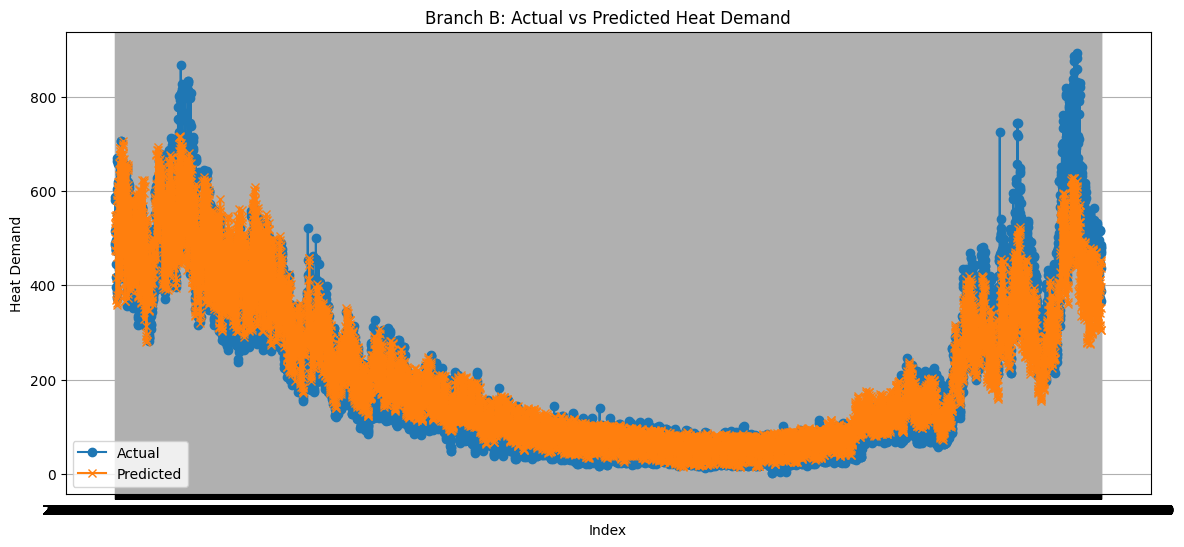

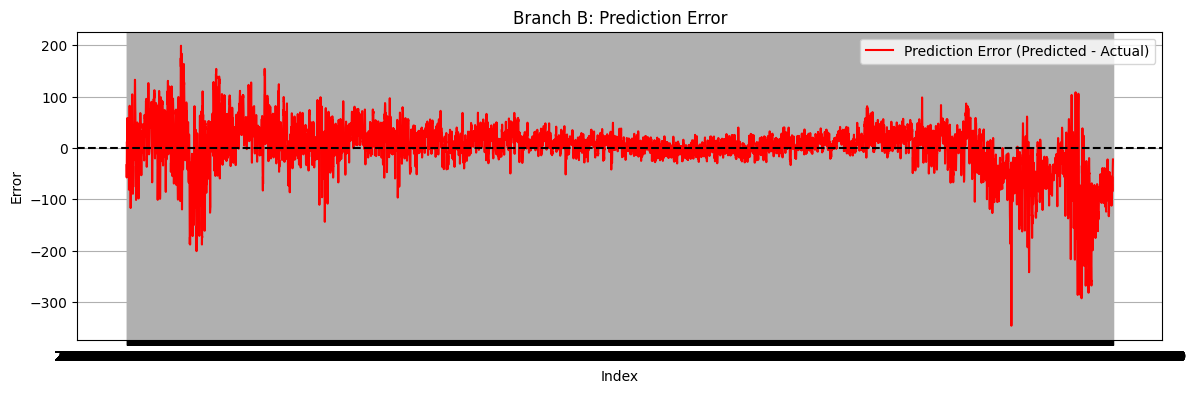

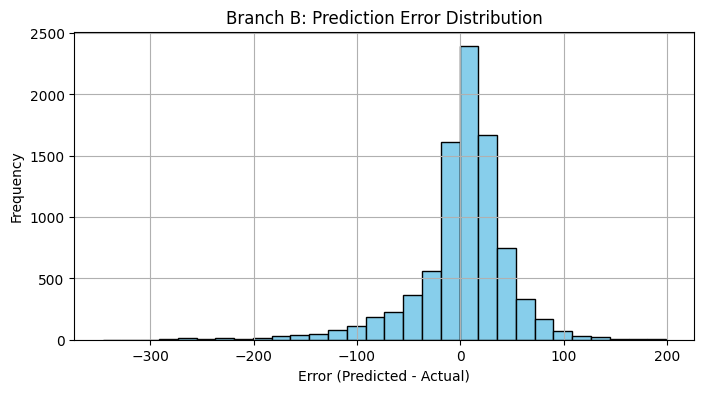

각 Fold의 Validation RMSE: [np.float64(97.66897597049369), np.float64(29.222809493851116)]
최종 평균 Validation RMSE: 63.4458927321724


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. branch_id가 'B'인 데이터만 추출
branch = 'B'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

# branch_id 컬럼 제거 (모델 입력에 불필요)
train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])

target_col = 'heat_demand'

# 2. 예측 수행
results = run_3fold_pipeline_with_residual(train_branch, test_branch, target_col)

# 3. 예측 결과 DataFrame 생성 (index 기준)
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']
}, index=results['test_index'])

# 4. 실제값과 예측값 비교를 위한 df_test_B 준비 (index 기준)
df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

# 5. 공통 인덱스만 사용해서 비교 (NaN 방지)
common_index = df_test_B.index.intersection(test_pred_B.index)
compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']

# 6. NaN이 남아있으면 제거
compare_df = compare_df.dropna()

# 7. RMSE, MAE 계산
rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
mae = np.mean(np.abs(compare_df['diff']))
print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 8. 실제값 vs 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
plt.title('Branch B: Actual vs Predicted Heat Demand')
plt.xlabel('Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid(True)
plt.show()

# 9. 오차 시계열 시각화
plt.figure(figsize=(14, 4))
plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error (Predicted - Actual)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Branch B: Prediction Error')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# 10. 오차 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Branch B: Prediction Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("각 Fold의 Validation RMSE:", results['val_rmses'])
print("최종 평균 Validation RMSE:", results['val_rmse'])

In [ ]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['actual'],
    mode='lines+markers', name='Actual', marker=dict(symbol='circle', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['predicted'],
    mode='lines+markers', name='Predicted', marker=dict(symbol='x', size=5)
))
fig.update_layout(
    title='Branch B: Actual vs Predicted Heat Demand',
    xaxis_title='Index',
    yaxis_title='Heat Demand',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=400
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['diff'],
    mode='lines+markers', name='Prediction Error', marker=dict(color='red', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=[0]*len(compare_df),  # 0선
    mode='lines', name='Zero Line', line=dict(color='black', dash='dash')
))
fig.update_layout(
    title='Branch B: Prediction Error',
    xaxis_title='Index',
    yaxis_title='Error',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=300
)
fig.show()